In [1]:
import sys
print(sys.version)

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]


In [11]:
import cv2
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

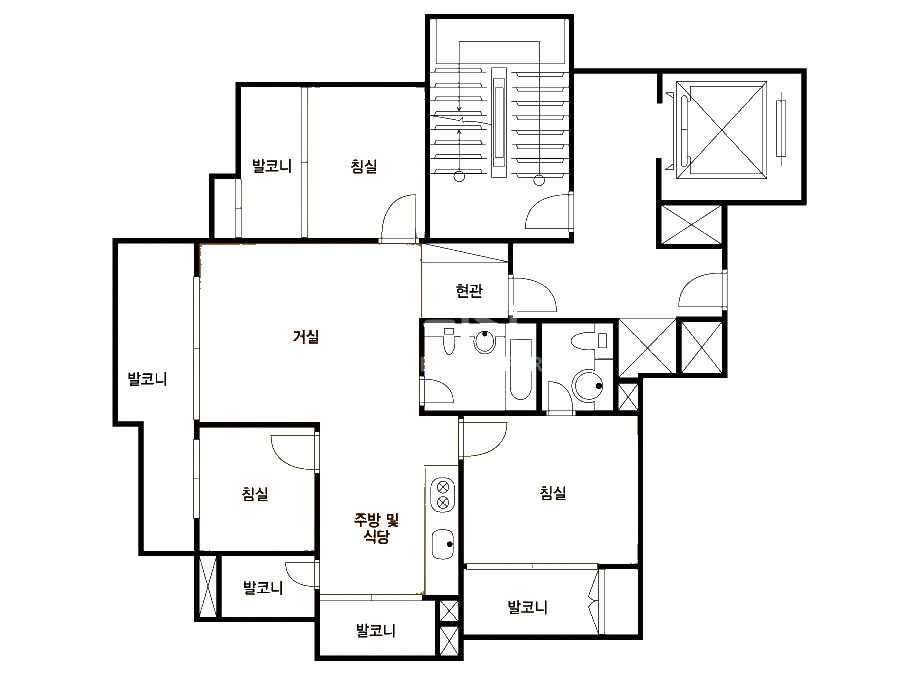

In [12]:
# 이미지 읽기
img_path = "../BT3_test/output1.png"
# img_path = "example.png"
img = cv2.imread(img_path)

display(Image.fromarray(img))

In [13]:
import easyocr
reader = easyocr.Reader(['ko','en'])
result = reader.readtext(img_path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [14]:
result

[([[248, 154], [296, 154], [296, 178], [248, 178]], '발코니', 0.9989707165870978),
 ([[349, 157], [379, 157], [379, 177], [349, 177]], '침실', 0.9994618271696872),
 ([[455, 281], [485, 281], [485, 301], [455, 301]], '현관', 0.9999964596665606),
 ([[291, 327], [321, 327], [321, 347], [291, 347]], '거실', 0.999915875926792),
 ([[125, 369], [169, 369], [169, 389], [125, 389]], '발코니', 0.9990452447095218),
 ([[241, 485], [269, 485], [269, 503], [241, 503]], '침실', 0.9998047813792929),
 ([[537, 483], [567, 483], [567, 503], [537, 503]], '침실', 0.9998751633170864),
 ([[350, 508], [402, 508], [402, 532], [350, 532]],
  '주방 및',
  0.9976536796542065),
 ([[361, 527], [393, 527], [393, 547], [361, 547]], '식당', 0.9999544817070392),
 ([[241, 577], [285, 577], [285, 597], [241, 597]], '발코니', 0.9996820328922328),
 ([[505, 597], [551, 597], [551, 617], [505, 617]], '발코니', 0.9938282205885154),
 ([[352, 618], [400, 618], [400, 642], [352, 642]], '발코니', 0.9964091365816694)]

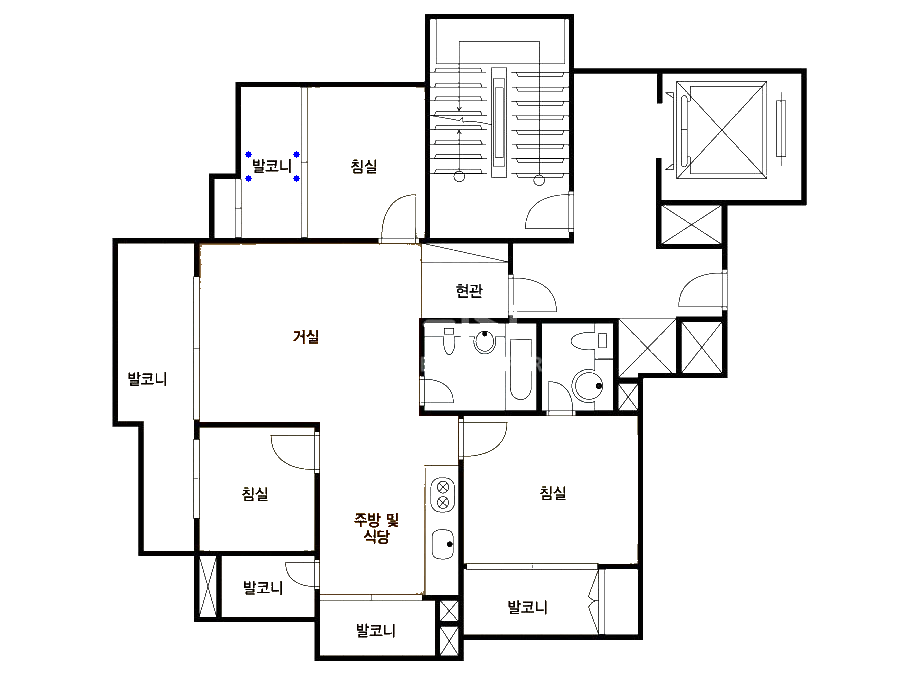

In [18]:
coor_img = img.copy()
# 점의 좌표 (예: x = 200, y = 100)
points = [[248, 154], [296, 154], [296, 178], [248, 178]]

# 점의 색상과 크기 설정
color = (0, 0, 255) # BGR 형식이므로 빨간색은 (0, 0, 255)
radius = 3  # 원(점)의 반지름

# 이미지에 원을 그려 점으로 표시. 원의 중심이 점의 위치가 됩니다.
for point in points:
    image_with_point = cv2.circle(coor_img, point, radius, color, -1)  # -1은 원을 채워 그리겠다는 의미입니다.

display(Image.fromarray(image_with_point))

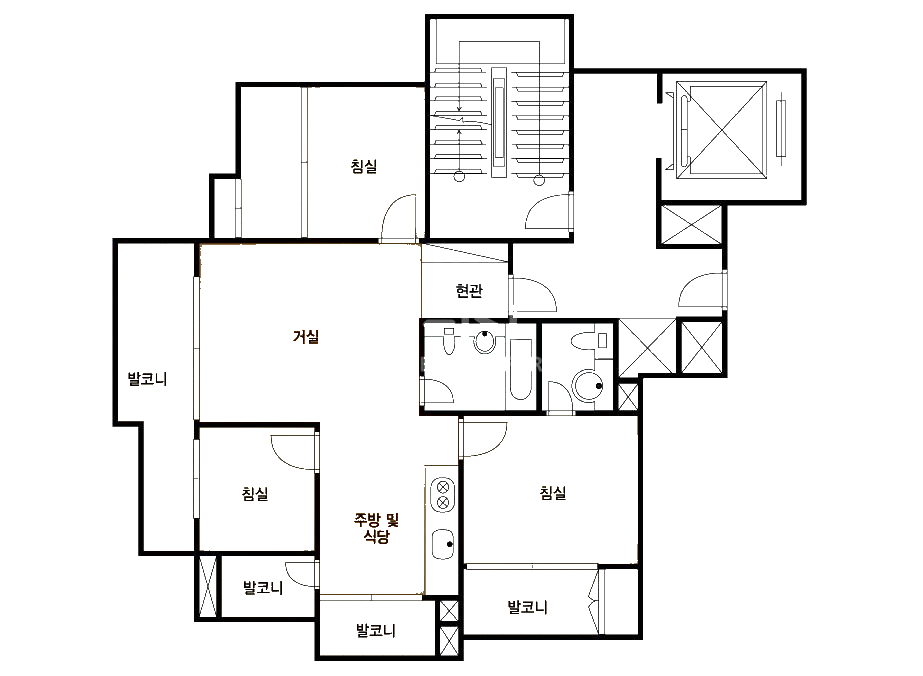

In [20]:
OCR_img = img.copy()

points = [[248, 154], [296, 154], [296, 178], [248, 178]]

# 사각형의 좌표: 시작점(왼쪽 상단)과 끝점(오른쪽 하단)
start_point = points[0]  # 사각형의 왼쪽 상단 모서리 (x, y)
end_point = points[2]    # 사각형의 오른쪽 하단 모서리 (x, y)

# 흰색으로 칠하기
color = (255, 255, 255)  # 흰색

# -1은 도형 내부를 채우는 데 사용되는 두께 값을 나타냅니다.
thickness = -1  # 모든 것을 채우려면 -1을 사용

# 이미지에 사각형 그리기
cv2.rectangle(OCR_img, start_point, end_point, color, thickness)

display(Image.fromarray(OCR_img))

In [ ]:
import cv2
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display
import easyocr

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


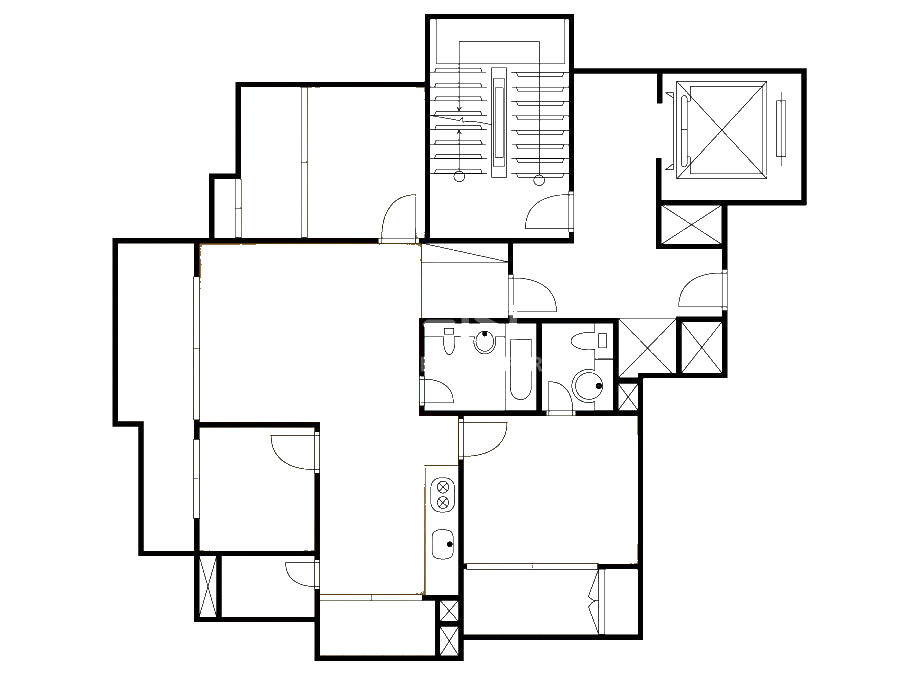

In [29]:
# 이미지 읽기
img_path = "../BT3_test/output1.png"
# img_path = "example.png"
img = cv2.imread(img_path)

reader = easyocr.Reader(['ko','en'])
results = reader.readtext(img_path)

OCR_img = img.copy()

for result in results:
    points = result[0]

    start_point = points[0]
    end_point = points[2]

    color = (255, 255, 255)

    thickness = -1  # 모든 것을 채우려면 -1을 사용

    cv2.rectangle(OCR_img, start_point, end_point, color, thickness)

cv2.imwrite("OCR_img.png", OCR_img)
display(Image.fromarray(OCR_img))

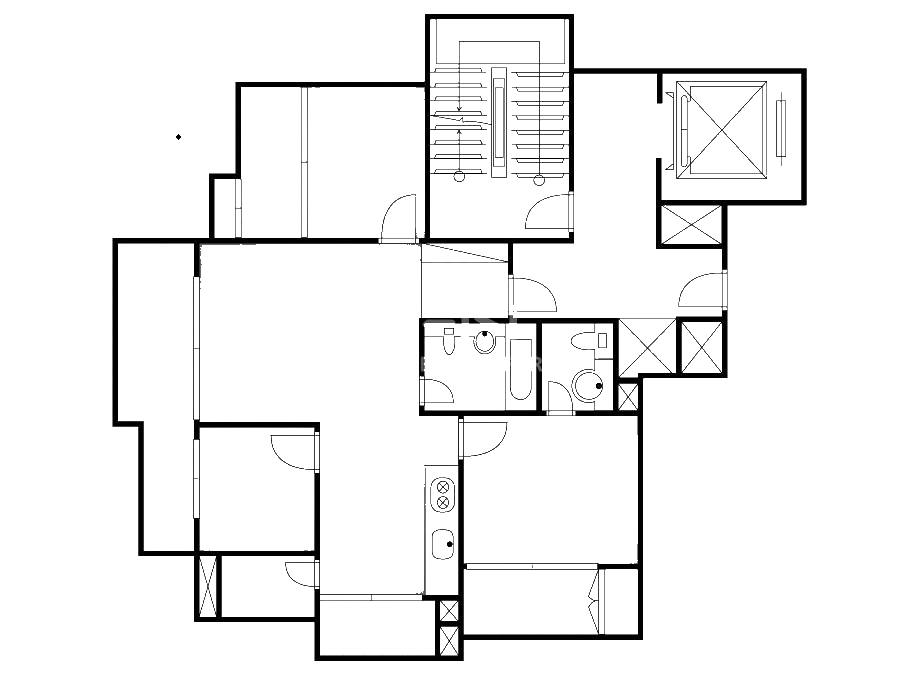

In [35]:
import cv2
import numpy as np

def find_pattern(main_image, template):
    # SIFT 기반의 특징 추출기 생성
    sift = cv2.SIFT_create()

    # 각 이미지에서 키포인트와 디스크립터 추출
    keypoints1, descriptors1 = sift.detectAndCompute(main_image, None)
    keypoints2, descriptors2 = sift.detectAndCompute(template, None)

    # FLANN 매처 생성
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # 검사할 트리 수

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # 두 이미지 간의 특징 매칭 수행
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # 좋은 매치점 필터링
    good_points = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_points.append(m)

    # 템플릿 이미지의 위치 찾기
    if len(good_points) > 10:
        query_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
        train_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)

        matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        # 투시 변환으로 문양의 경계를 찾습니다.
        h, w = template.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)

        # 메인 이미지에 문양의 사각형 경계를 그립니다.
        main_image = cv2.polylines(main_image, [np.int32(dst)], True, (0, 255, 0), 3)

        display(Image.fromarray(main_image))
    else:
        print("Not enough matches are found - %d/%d" % (len(good_points), 10))


# test_img = img.copy()

# main_image = test_img
main_image = cv2.imread("OCR_img.png", cv2.IMREAD_GRAYSCALE)
template = cv2.imread('door_4.png', cv2.IMREAD_GRAYSCALE)
find_pattern(main_image, template)


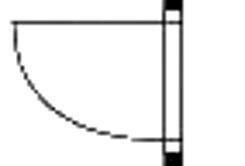

[[-0.03553675 -0.03571375 -0.03588993 ... -0.0517793  -0.04810084
  -0.04598377]
 [-0.03573912 -0.03591023 -0.03609043 ... -0.05143018 -0.04763826
  -0.04553194]
 [-0.03594536 -0.03612047 -0.03628987 ... -0.05105612 -0.04722812
  -0.04513121]
 ...
 [-0.0448323  -0.04509461 -0.04535829 ...  0.          0.
   0.        ]
 [-0.04465298 -0.04491594 -0.04518025 ...  0.          0.
   0.        ]
 [-0.04447071 -0.04473431 -0.04500179 ...  0.          0.
   0.        ]]
(array([ 61,  61,  61,  61,  61,  61,  62,  62,  62,  62,  62,  62,  62,
        63,  63,  63,  63, 389, 389, 389, 390, 390, 390, 390, 390, 390,
       391, 391, 391, 391, 391, 391, 392, 392, 392, 392], dtype=int64), array([245, 246, 247, 248, 263, 264, 245, 246, 247, 248, 262, 263, 264,
       246, 247, 263, 264, 460, 476, 477, 459, 460, 461, 475, 476, 477,
       459, 460, 461, 475, 476, 477, 459, 460, 476, 477], dtype=int64))


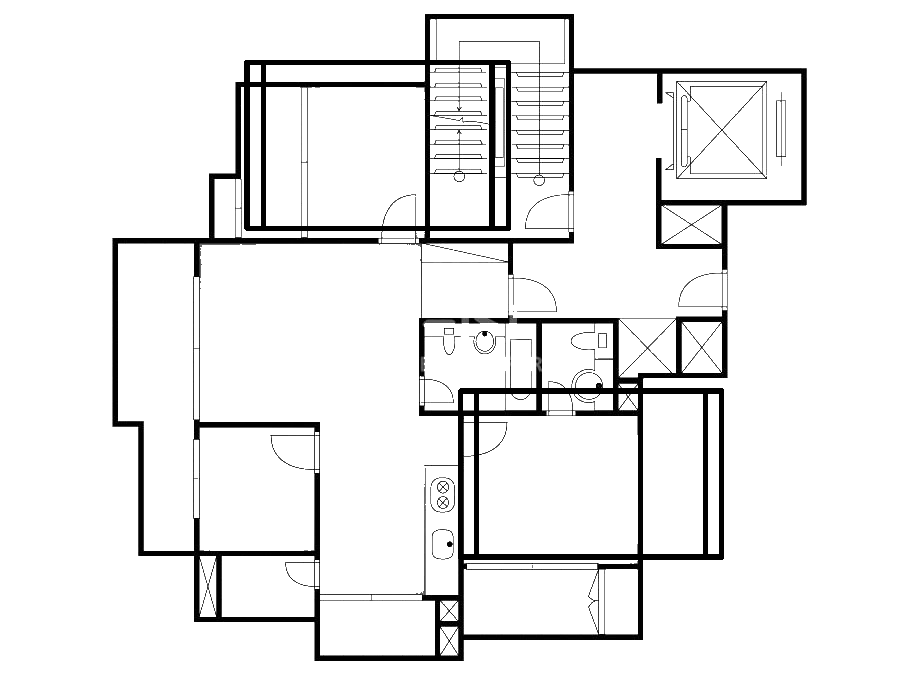

In [42]:
import cv2
import numpy as np

# 주어진 도면과 문 템플릿 이미지를 로드
main_image = cv2.imread('OCR_img.png', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('door_4.png', cv2.IMREAD_GRAYSCALE)  # 'door_template.png'는 문 이미지의 경로
display(Image.fromarray(template))

# 템플릿 매칭 수행
result = cv2.matchTemplate(main_image, template, cv2.TM_CCOEFF_NORMED)
print(result)

# 문과 유사한 부분 찾기 (예: 매칭 점수가 0.8 이상인 부분)
threshold = 0.4
loc = np.where(result >= threshold)
print(loc)
# 문과 유사한 부분에 사각형 그리기
for pt in zip(*loc[::-1]):
    cv2.rectangle(main_image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 0, 255), 2)

# 결과 이미지 표시
display(Image.fromarray(main_image))


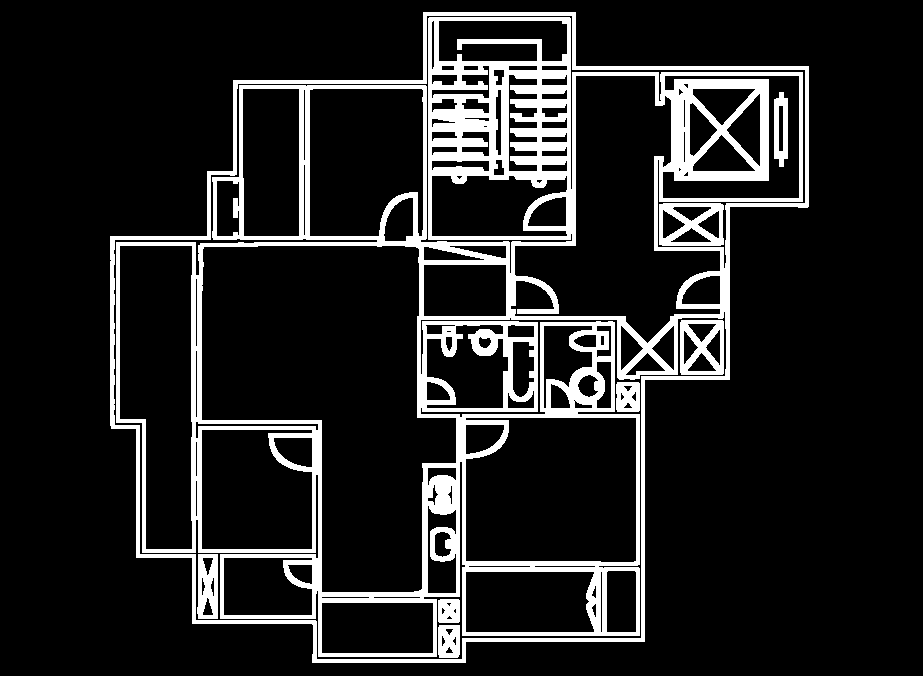

In [47]:
import cv2
import numpy as np

# 이미지 로드
image = cv2.imread('OCR_img.png', cv2.IMREAD_GRAYSCALE)

# 임계값을 적용하여 이진 이미지 생성
_, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# 모폴로지 변환을 위한 커널 생성
kernel = np.ones((5, 5), np.uint8)

# 모폴로지 그라디언트 연산 적용
gradient = cv2.morphologyEx(binary, cv2.MORPH_GRADIENT, kernel)

# 결과 이미지 표시
display(Image.fromarray(gradient))